## To do list for this code
- regionally averaged correlation patterns

In [12]:
import cde_net_functions as cn

import os
import numpy as np

import pandas as pd
import copy 
import networkx as nx
import itertools
# import community
import random
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scipy import signal
from scipy import stats
from scipy import io
from scipy import optimize
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import axes3d
import ants
import pandas as pd
from imp import reload
import re
import pickle

# Jupyter specific autoreloading for external functions (in case changes are made)
%load_ext autoreload
%autoreload
# %matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Housekeeping and the like
Note that most of the functions below rely on you having run `cde_cell` and `cde_reg` 

In [13]:
# Define manually
#---------------------------------------------------------------------------
F             = {}
F["Fbase"]    = '/Users/roschkoenig/Dropbox/Research/1901 Fish2p/suite2p data'
F["Fscripts"] = '/Users/roschkoenig/Dropbox/Research/1812 Critical Dynamics Epilepsy'
F["Fdata"]    = '/Users/roschkoenig/Dropbox/Research/1812 Critical Dynamics Epilepsy Data'

# Specify automatically
#---------------------------------------------------------------------------
F["Fanalysis"] = Fdata + os.sep + 'Analysis'
F["Fcmn"]      = Fanalysis + os.sep + 'CMN'
F["Ftemps"]    = Fdata + os.sep + 'Templates'
F["Ftrans"]    = Ftemps + os.sep + 'CF2REF'
F["Freg"]      = Fanalysis + os.sep + 'Registration'

# Load fish data from data folder and 
#---------------------------------------------------------------------------
Fish  = cn.load(F["Fcmn"])

I found 1 datasets
Loading dataset ZFRR004_02


In [14]:
# Define fish of interest and load / map registration results
#---------------------------------------------------------------------------
foi = 0 
cn.atlasmap(Fish[foi], F)
Fish[foi] = cn.atlasload(Fish[foi], F)

Checking / Making atlases for BL
Checking / Making atlases for PTZ


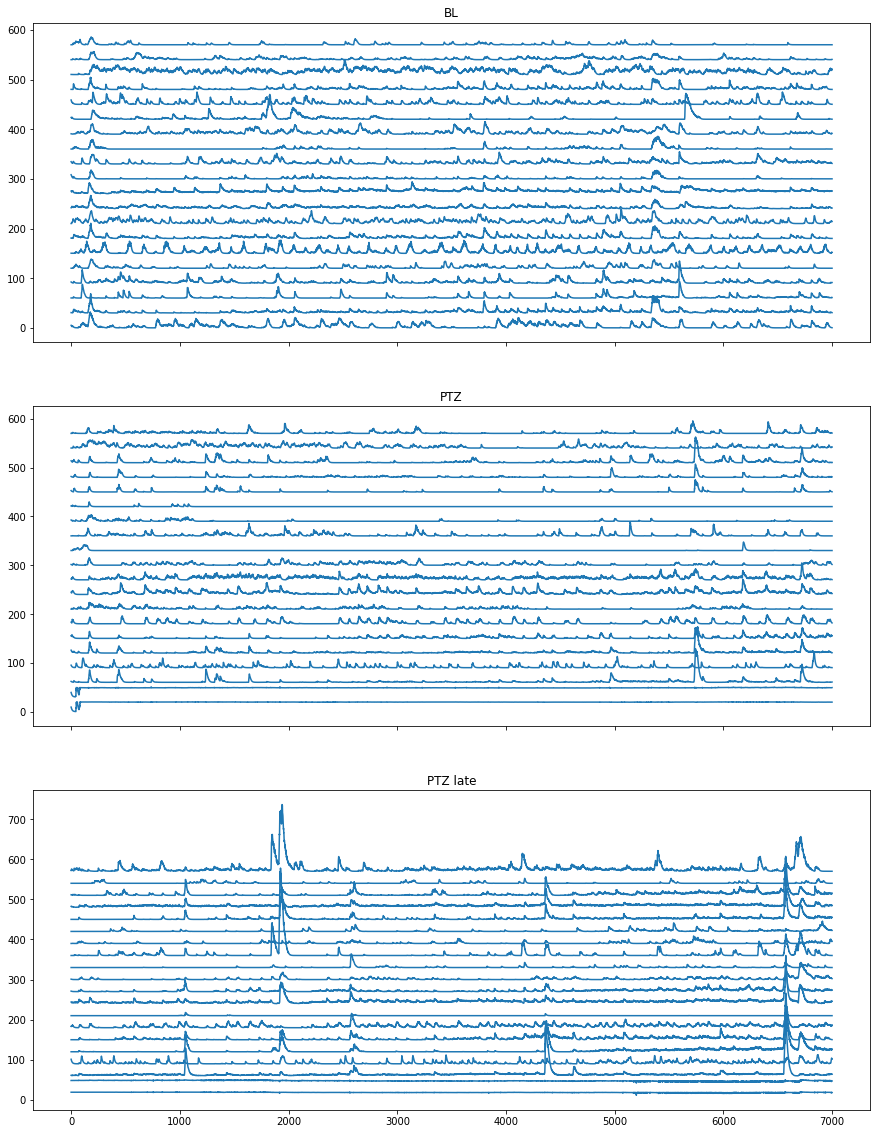

In [15]:
# Plot example outputs
#---------------------------------------------------------------------------
nplt     = 20
f, axarr = plt.subplots(3, sharex=True, figsize=(15,20))

for c in range(2):
    d     = Fish[foi]["Cond"][c]["Data"][:nplt,:7000]
    cm    = plt.get_cmap("Paired")
    
    axarr[c].set_title(Fish[foi]["Cond"][c]["Name"])
    for i in range(nplt):
        axarr[c].plot(d[i,:] + 30*i, c=cm(1))

d = Fish[foi]["Cond"][c]["Data"][:nplt, -7000:]
axarr[2].set_title('PTZ late')
for i in range(nplt):
    axarr[2].plot(d[i,:] + 30*i, c = cm(1))


## Detect peaks for further analysis

In [16]:
for c in range(len(Fish[foi]["Cond"])):
    
    # Detect peaks in ncells * ntime points data
    #----------------------------------------------------------------
    pks = cn.peaks(Fish[foi]["Cond"][c]["Data"])
    Fish[foi]["Cond"][c]["Peaks"] = pks

    # Set up random shuffled array for comparison
    #----------------------------------------------------------------
    rpks = copy.deepcopy(pks)
    rpks = rpks.ravel()
    np.random.shuffle(rpks) 
    rpks = np.reshape(rpks, pks.shape)

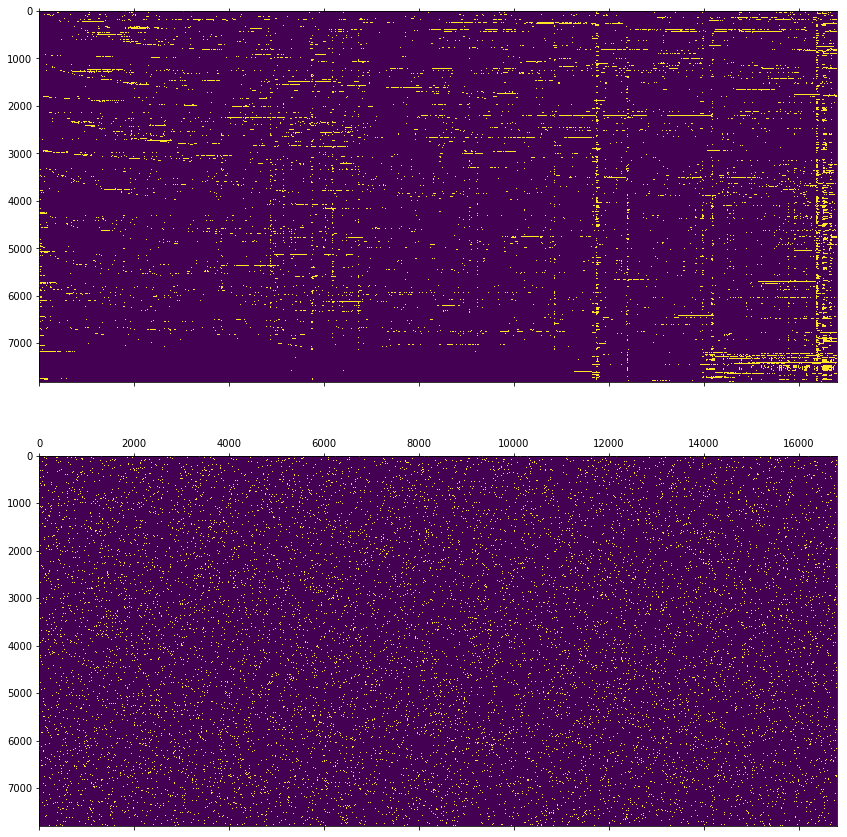

In [17]:
# Plot a section of the detected peaks
#---------------------------------------------------------------------
f, ax = plt.subplots(2, sharex=True, figsize=(15,15))
ax[0].matshow(pks)
ax[1].matshow(rpks)

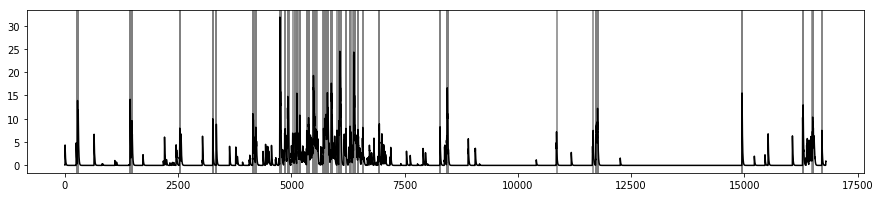

In [18]:
# Plot an illustrative example
#----------------------------------------------------------------------------------------
pks = Fish[foi]["Cond"][1]["Peaks"]
pi  = 100
# Actual plotting routines
#----------------------------------------------------------------------------------------
plt.figure(figsize = (15,3))
for x in np.where(pks[pi,:])[0]: plt.axvline(x=x, c='gray')
plt.plot(Fish[foi]["Cond"][1]["Data"][pi,:], c = 'black')

## Initial Network Analysis

In [19]:
# Set up nearest neighbour graph
#---------------------------------------------------------------------------
reload(cn)
for c in range(len(Fish[foi]["Cond"])):
    cs        = Fish[foi]["Cond"][c]["Coordinates"]
    nnb, dis  = cn.nneigh(cs, cnt=1, fullmat = True)
    Fish[foi]["Cond"][c]["NNGraph"]   = nnb
    Fish[foi]["Cond"][c]["Distances"] = dis

Doing row 0 of 6734
Doing row 673 of 6734
Doing row 1346 of 6734
Doing row 2019 of 6734
Doing row 2692 of 6734
Doing row 3365 of 6734
Doing row 4038 of 6734
Doing row 4711 of 6734
Doing row 5384 of 6734
Doing row 6057 of 6734
Doing row 6730 of 6734
Done
Doing row 0 of 7808
Doing row 781 of 7808
Doing row 1562 of 7808
Doing row 2343 of 7808
Doing row 3124 of 7808
Doing row 3905 of 7808
Doing row 4686 of 7808
Doing row 5467 of 7808
Doing row 6248 of 7808
Doing row 7029 of 7808
Done


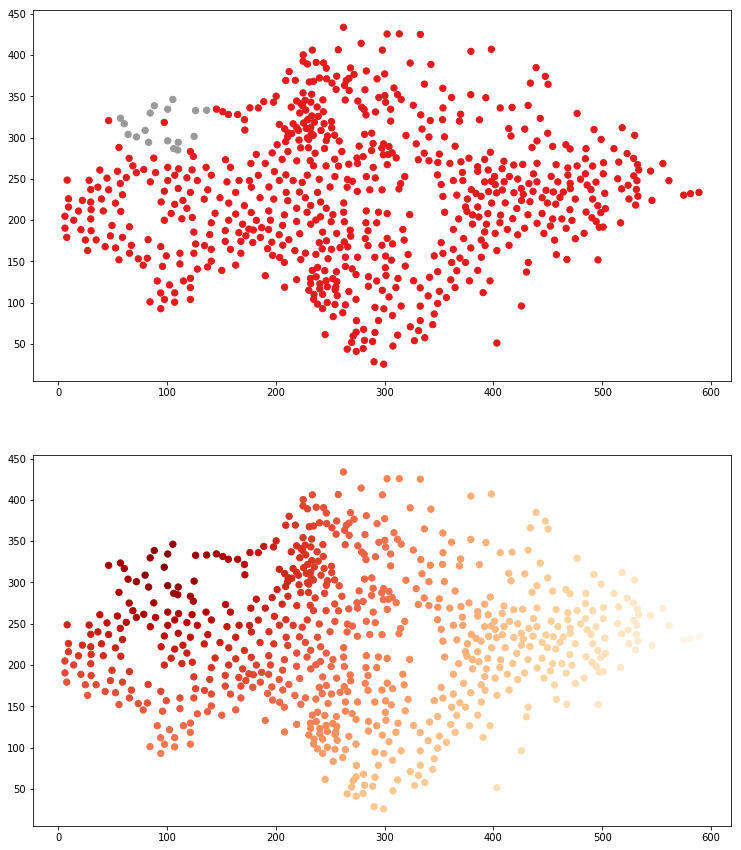

In [20]:
# Plot an illustrative example
#----------------------------------------------------------------------------------------
plane = 7
c     = 1

# Pull out the data from fish structure
#----------------------------------------------------------------------------------------
bmi  = Fish[foi]["Cond"][c]["Features"]["Brain Mask"] == 1
cs   = Fish[foi]["Cond"][c]["Coordinates"][bmi,:]  # 3D array of xyz coordinates
nnb  = Fish[foi]["Cond"][c]["NNGraph"][:,bmi][bmi,:]
dis  = Fish[foi]["Cond"][c]["Distances"][:,bmi][bmi,:]
pl   = np.unique(cs[:,2])[plane]
ci   = np.where(cs[:,2] == pl)[0]        # Index of plane coordinates in long list


# Actual plotting routines
#----------------------------------------------------------------------------------------
fig, ax = plt.subplots(2,1, figsize = (12.5,15))
ax[0].scatter(cs[ci,0], cs[ci,1], s = 40, c = nnb[ci[0],ci], cmap = 'Set1')
ax[1].scatter(cs[ci,0], cs[ci,1], s = 40, c = dis[ci[0],ci], cmap = 'OrRd_r')


In [21]:
for c in range(len(Fish[foi]["Cond"])):
    bmi  = Fish[foi]["Cond"][c]["Features"]["Brain Mask"] == 1
    cs   = Fish[foi]["Cond"][c]["Coordinates"][bmi,:]
    Fish[foi]["Cond"][c]["C2K"] = cn.spacek(cs)


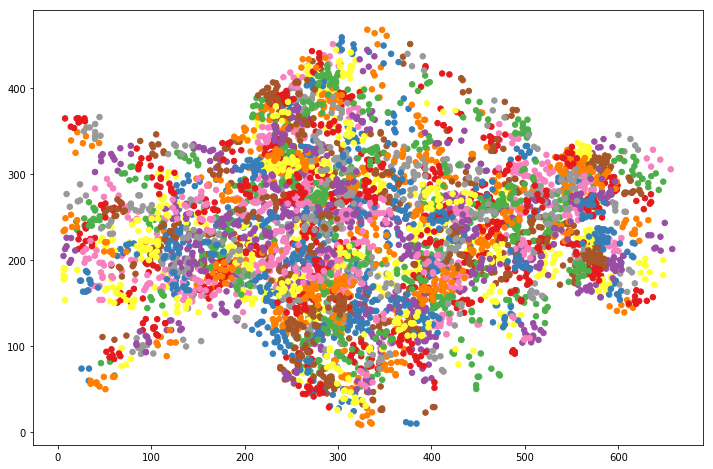

In [22]:
# Plot an illustrative exxample
c     = 1
plane = 'all'
bmi   = Fish[foi]["Cond"][c]["Features"]["Brain Mask"] == 1
cs    = Fish[foi]["Cond"][c]["Coordinates"][bmi,:]
ks    = Fish[foi]["Cond"][c]["C2K"]

if plane == 'all': cid = range(cs.shape[0])
else: 
    zval  = np.unique(cs[:,2])[plane]
    cid   = np.where(cs[:,2] == zval)[0]

plt.figure(figsize = (12, 8))
plt.scatter(cs[cid,0], cs[cid,1], s = 30, c = ks[cid], cmap = 'Set1')

## Import features into the fish object
### Voxel-based coordinates (for looking up in transformed ZBB images)

### Atlas labels

In [9]:
# Map templates from transgenic lines to subject space and save
#========================================================================
reload(cn)
templist = os.listdir(Ftemps +os.sep+ 'Transgenic')
r        = re.compile('[A-Za-z].+\.tif$')
temps    = list(filter(r.match, templist))

for c in range(len(Fish[foi]["Cond"])):
    i = 0
    T = []
    for t in temps: 
        i = i + 1
        print('Currently working on file ' + str(i) + ' of ' + str(len(temps)))
        zbb = ants.image_read(Ftemps +os.sep+ 'Transgenic' +os.sep+ t)
        name = t[:-4]
        path = Ftemps +os.sep+ 'Transgenic' +os.sep + t
        imgt = cn.revreg(Fish[foi], zbb, Ftemps, Ftrans, Freg)
        T.append({"Name":name, "Path":path, "Imgt":imgt})

    Fatlas = Freg + os.sep + Fish[foi]["Name"] + os.sep + Fish[foi]["Cond"][c]["Name"] +os.sep+ 'Transgenic'
    if not os.path.exists(Fatlas): os.makedirs(Fatlas)
    for t in T:
        ants.image_write(t["Imgt"], Fatlas +os.sep+ t["Name"] + '.tif')


Currently working on file 1 of 51
Currently working on file 2 of 51
Currently working on file 3 of 51
Currently working on file 4 of 51
Currently working on file 5 of 51
Currently working on file 6 of 51
Currently working on file 7 of 51
Currently working on file 8 of 51
Currently working on file 9 of 51
Currently working on file 10 of 51
Currently working on file 11 of 51
Currently working on file 12 of 51
Currently working on file 13 of 51
Currently working on file 14 of 51
Currently working on file 15 of 51
Currently working on file 16 of 51
Currently working on file 17 of 51
Currently working on file 18 of 51
Currently working on file 19 of 51
Currently working on file 20 of 51
Currently working on file 21 of 51
Currently working on file 22 of 51
Currently working on file 23 of 51
Currently working on file 24 of 51
Currently working on file 25 of 51
Currently working on file 26 of 51
Currently working on file 27 of 51
Currently working on file 28 of 51
Currently working on file 29 

### Quantitative information from expression data

In [23]:
for c in range(len(Fish[foi]["Cond"])):
    ocs       = Fish[foi]["Cond"][c]["OCoord"]
    Fquant    = Freg + os.sep + Fish[foi]["Name"] + os.sep + Fish[foi]["Cond"][c]["Name"] +os.sep+ 'Transgenic'
    r         = re.compile('^[a-zA-Z].+\.tif$')
    tfiles   = list(filter(r.match, os.listdir(Fquant)))

    i = 0
    for t in tfiles: 
        i = i + 1
        print('Processing ' + str(i) + ' of ' + str(len(tfiles)) + ' images')
        timg  = ants.image_read(Fquant +os.sep+ t)
        tf    = np.array((0))
        for o in ocs:
            tf = np.append(tf, timg[int(o[0]), int(o[1]), int(o[2])])
        
        Fish[foi]["Cond"][c]["Features"][t[:-4]] = tf[1:]
    


Processing 1 of 51 images
Processing 2 of 51 images
Processing 3 of 51 images
Processing 4 of 51 images
Processing 5 of 51 images
Processing 6 of 51 images
Processing 7 of 51 images
Processing 8 of 51 images
Processing 9 of 51 images
Processing 10 of 51 images
Processing 11 of 51 images
Processing 12 of 51 images
Processing 13 of 51 images
Processing 14 of 51 images
Processing 15 of 51 images
Processing 16 of 51 images
Processing 17 of 51 images
Processing 18 of 51 images
Processing 19 of 51 images
Processing 20 of 51 images
Processing 21 of 51 images
Processing 22 of 51 images
Processing 23 of 51 images
Processing 24 of 51 images
Processing 25 of 51 images
Processing 26 of 51 images
Processing 27 of 51 images
Processing 28 of 51 images
Processing 29 of 51 images
Processing 30 of 51 images
Processing 31 of 51 images
Processing 32 of 51 images
Processing 33 of 51 images
Processing 34 of 51 images
Processing 35 of 51 images
Processing 36 of 51 images
Processing 37 of 51 images
Processing

### Quantitative information from dynamics

#### Firing probability

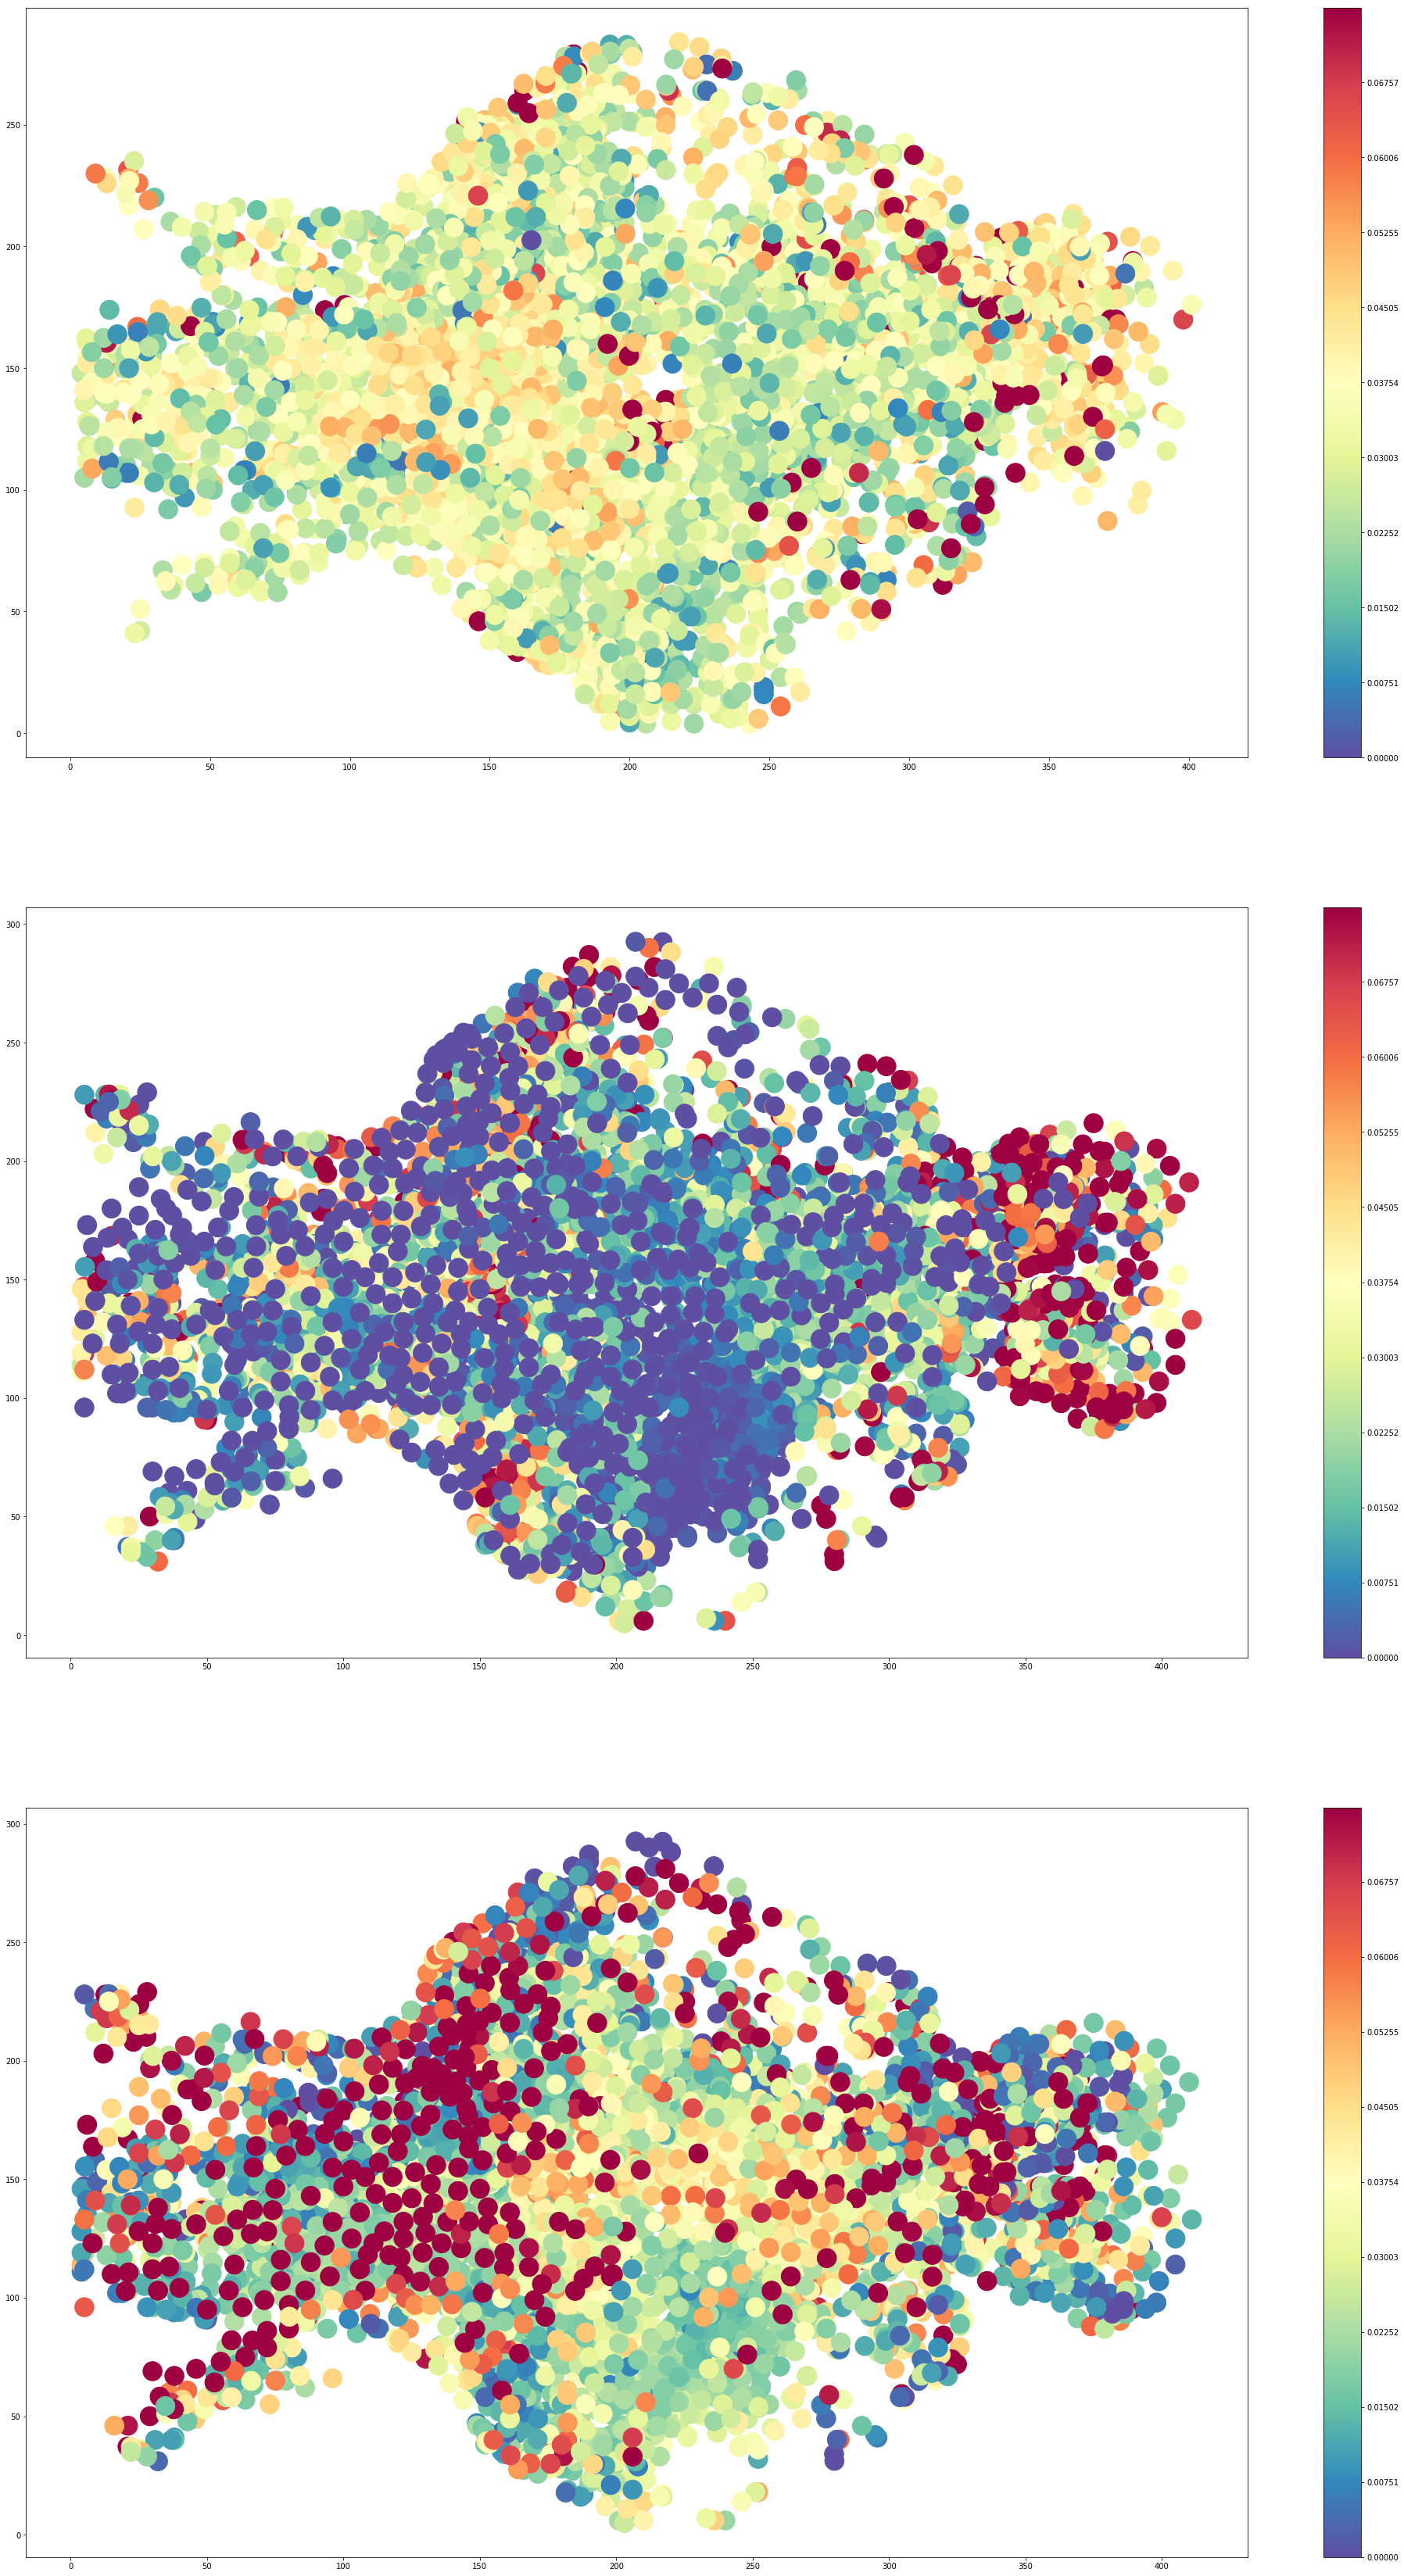

In [98]:
reload(cn)
clims   = [0, .075]
bounds  = np.linspace(clims[0], clims[1], 1000)
cmap    = 'Spectral_r'

# Generate data to be plotted
#------------------------------------------------------------------------------
pf_bl   = cn.winslide(Fish[foi]["Cond"][0], mtype = 'p_firing')
pf_pt   = cn.winslide(Fish[foi]["Cond"][1], mtype = 'p_firing')

# Generate three subplots: Baseline, Early PTZ, Late PTZ
#------------------------------------------------------------------------------
fig, ax = plt.subplots(3,1, figsize = (35,60))

pl_bl   = cn.fishdot(Fish[foi]["Cond"][0], np.mean(pf_bl[:,:], axis = 1), 
                     ax[0], cmap = cmap)
cl_bl   = fig.colorbar(pl_bl, ax = ax[0], boundaries = bounds)
cl_bl.set_clim(clims)

pl_p1   = cn.fishdot(Fish[foi]["Cond"][1], np.mean(pf_pt[:,:30], axis = 1), 
                     ax[1], cmap = cmap)
cl_p1   = fig.colorbar(pl_p1, ax = ax[1], boundaries = bounds)
cl_p1.set_clim(clims)

pl_p2   = cn.fishdot(Fish[foi]["Cond"][1], np.mean(pf_pt[:,30:], axis = 1),
                     ax[2], cmap = cmap)
cl_p2   = fig.colorbar(pl_p2, ax = ax[2], boundaries = bounds)
cl_p2.set_clim(clims)

In [611]:
# Plot by region and by label
#==============================================================================
# Generate data to be plotted
#------------------------------------------------------------------------------
pf_bl   = cn.winslide(Fish[foi]["Cond"][0], mtype = 'p_firing')
pf_pt   = cn.winslide(Fish[foi]["Cond"][1], mtype = 'p_firing')

# Load label look up table
#------------------------------------------------------------------------------
lut = pd.read_csv(Ftemps +os.sep+ 'z-atlas_codes.csv')
bre = pd.unique(lut["Brain Region"])

# Get regional labels for specific cells 
#------------------------------------------------------------------------------
fish = Fish[foi]["Cond"][0]
valb = Fish[foi]["Cond"][0]["Features"]["Z-brain"].round()
regb = vals.unique()

valp = Fish[foi]["Cond"][1]["Features"]["Z-brain"].round()
regp = vals.unique()

regs = list(set(regb) & set(regp))
    
# Plot pre-post PTZ relationship in firing
#-----------------------------------------------------------------------------
regvals = pd.DataFrame()
pfb = []; pf1 = []; pf2 = []; lab = []; llb = []; li = []; nne = []


for r in regs:
    cib = np.where(valb == r)[0]           # find cells matching region in baseline
    cip = np.where(valp == r)[0]           # find cells matching region in PTZ
    
    if (cib.shape[0] > 0) & (cip.shape[0] > 0):
        # Pack three lists for the different conditions
        #–-----------------------------------------------------------------------
        pfb.append(np.mean(pf_bl[cib,:]))      
        pf1.append(np.mean(pf_pt[cip,:30]))
        pf2.append(np.mean(pf_pt[cip,30:]))
        nne.append(np.log(np.mean([len(cib),len(cip)])) * 100)

        # Find brain gross anatomy regions for colour coding
        #-----------------------------------------------------------------------
        lab.append(lut["Brain Region"][lut["Number code"] == r].to_string(index = False))
        llb.append(lut["Structure"][lut["Number code"] == r].to_string(index = False))

li = np.array([])
for l in lab: li = np.hstack((li, np.where(bre == l)[0][0]))        # whyyyyy do you need so many empty indices, np.where????
    
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, figsize = (40,15))
ax[0].scatter(pfb, pf1, s = nne, c = li, cmap = 'Dark2')
ax[0].plot((0,.1), (0,.1), ls="--", c=".3")
ax[1].scatter(pfb, pf2, s = nne, c = li, cmap = 'Dark2')
ax[1].plot((0,.1), (0,.1), ls="--", c=".3")

# for p in range(len(pfb)):
#     ax[0].annotate(llb[p], (pfb[p],pf1[p]))
#     ax[1].annotate(llb[p], (pfb[p],pf2[p]))
    
fig.savefig(Ftemps +os.sep+ 'Firing_rate_nolab.pdf', dpi=300, orientation='landscape', transparent=True)

#### Local connectivity kernel

In [715]:
# Generate data to be plotted
#------------------------------------------------------------------------------
cw_bl   = cn.winslide(Fish[foi]["Cond"][0], mtype = 'spatial')
cw_pt   = cn.winslide(Fish[foi]["Cond"][1], mtype = 'spatial')

Working on time step 1 of 30
Working on time step 2 of 30
Working on time step 3 of 30
Working on time step 4 of 30
Working on time step 5 of 30
Working on time step 6 of 30
Did not optimise cell 4428
Working on time step 7 of 30
Working on time step 8 of 30
Working on time step 9 of 30
Did not optimise cell 2906
Working on time step 10 of 30
Working on time step 11 of 30
Did not optimise cell 800
Working on time step 12 of 30
Working on time step 13 of 30
Did not optimise cell 436
Working on time step 14 of 30
Working on time step 15 of 30


/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Working on time step 16 of 30
Working on time step 17 of 30
Did not optimise cell 2644
Did not optimise cell 5032
Working on time step 18 of 30
Working on time step 19 of 30
Did not optimise cell 6352
Working on time step 20 of 30
Working on time step 21 of 30
Working on time step 22 of 30
Did not optimise cell 5352
Working on time step 23 of 30
Did not optimise cell 2076
Working on time step 24 of 30
Did not optimise cell 848
Did not optimise cell 1321
Working on time step 25 of 30
Working on time step 26 of 30
Did not optimise cell 30
Working on time step 27 of 30
Working on time step 28 of 30
Working on time step 29 of 30
Did not optimise cell 1094
Working on time step 1 of 70
Working on time step 2 of 70
Working on time step 3 of 70
Did not optimise cell 6084
Working on time step 4 of 70
Working on time step 5 of 70
Did not optimise cell 2376
Did not optimise cell 5378
Working on time step 6 of 70


/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Did not optimise cell 3590
Did not optimise cell 6284
Did not optimise cell 6738
Working on time step 7 of 70
Working on time step 8 of 70
Did not optimise cell 2989
Working on time step 9 of 70
Working on time step 10 of 70
Did not optimise cell 3588
Working on time step 11 of 70
Working on time step 12 of 70
Did not optimise cell 1514


/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Working on time step 13 of 70
Did not optimise cell 7059
Working on time step 14 of 70
Did not optimise cell 1719
Did not optimise cell 3106
Working on time step 15 of 70
Working on time step 16 of 70
Working on time step 17 of 70
Did not optimise cell 426
Did not optimise cell 6338
Working on time step 18 of 70
Working on time step 19 of 70
Did not optimise cell 4566
Did not optimise cell 7161
Working on time step 20 of 70
Working on time step 21 of 70
Working on time step 22 of 70
Working on time step 23 of 70
Did not optimise cell 6071
Did not optimise cell 6216
Did not optimise cell 6323
Working on time step 24 of 70
Working on time step 25 of 70


/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Did not optimise cell 6270
Working on time step 26 of 70
Did not optimise cell 2069
Working on time step 27 of 70
Did not optimise cell 975
Working on time step 28 of 70
Working on time step 29 of 70
Did not optimise cell 1567
Working on time step 30 of 70
Did not optimise cell 4747
Working on time step 31 of 70
Did not optimise cell 1366
Did not optimise cell 4985
Did not optimise cell 5643
Did not optimise cell 6723
Working on time step 32 of 70
Did not optimise cell 5309
Working on time step 33 of 70
Working on time step 34 of 70
Working on time step 35 of 70
Did not optimise cell 6945
Working on time step 36 of 70
Working on time step 37 of 70
Did not optimise cell 758
Working on time step 38 of 70
Did not optimise cell 592
Working on time step 39 of 70
Working on time step 40 of 70
Did not optimise cell 123
Did not optimise cell 1910
Did not optimise cell 3772
Working on time step 41 of 70
Did not optimise cell 879
Did not optimise cell 1336
Working on time step 42 of 70
Did not o

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Did not optimise cell 6583
Working on time step 58 of 70
Did not optimise cell 2955
Working on time step 59 of 70
Working on time step 60 of 70
Did not optimise cell 2847
Working on time step 61 of 70
Working on time step 62 of 70
Working on time step 63 of 70
Working on time step 64 of 70
Working on time step 65 of 70
Did not optimise cell 2130
Working on time step 66 of 70
Did not optimise cell 3774
Working on time step 67 of 70
Did not optimise cell 706
Working on time step 68 of 70
Did not optimise cell 1437
Did not optimise cell 4895
Did not optimise cell 5592
Working on time step 69 of 70


In [738]:
reload(cn)
clims   = [0, 120]
bounds  = np.linspace(clims[0], clims[1], 1000)
cmap    = 'RdBu_r'

# Generate three subplots: Baseline, Early PTZ, Late PTZ
#------------------------------------------------------------------------------
fig, ax = plt.subplots(3,1, figsize = (35,60))

bmi     = Fish[foi]["Cond"][0]["Features"]["Brain Mask"] == 1
pl_bl   = cn.fishdot(Fish[foi]["Cond"][0], np.nanmean(cw_bl[1:,:], axis = 1), 
                     ax[0], cmap = cmap)
cl_bl   = fig.colorbar(pl_bl, ax = ax[0], boundaries = bounds)
cl_bl.set_clim(clims)

pl_p1   = cn.fishdot(Fish[foi]["Cond"][1], np.nanmean(cw_pt[1:,:30], axis = 1), 
                     ax[1], cmap = cmap)
cl_p1   = fig.colorbar(pl_p1, ax = ax[1], boundaries = bounds)
cl_p1.set_clim(clims)

pl_p2   = cn.fishdot(Fish[foi]["Cond"][1], np.nanmean(cw_pt[1:,30:], axis = 1),
                     ax[2], cmap = cmap)
cl_p2   = fig.colorbar(pl_p2, ax = ax[2], boundaries = bounds)
cl_p2.set_clim(clims)

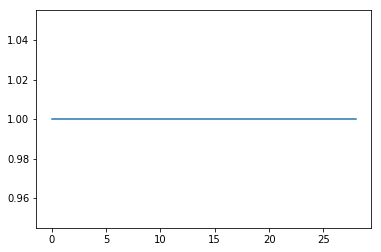

In [729]:
plt.plot(cw_bl[0,:])

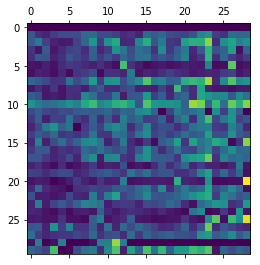

In [714]:
plt.matshow(cw[:30,:])

/Users/roschkoenig/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:3181: RuntimeWarning: invalid value encountered in true_divide
  return c / c


nan

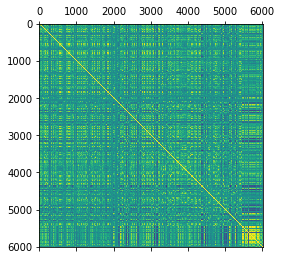

In [336]:
plt.matshow(cor)

This plot shows the decay of correlation over spatial (euclidean) distance - this indicates the spatial correlation kernel that best describes the average cell-to-cell correlation patterns

This plot illustrates a possible model for the decay function empirically described above. This model is specified with two parameters - namely 'width' (representing the width of the function at 50% of the decay) and 'height'

In [408]:
reload(cn)
from cde_net_functions import modelfunctions as mf

popt, pcov = optimize.curve_fit(mf('decay'), bounds[:-1], cv)
plt.plot(bounds[:-1], mf('decay')(bounds[:-1], popt[0], popt[1]))

popt, pcov = optimize.curve_fit(mf('norm'), bounds[:-1], cv)
plt.plot(bounds[:-1], mf('norm')(bounds[:-1], popt[0], popt[1]))

popt, pcov = optimize.curve_fit(mf('mixed'), bounds[:-1], cv)
plt.plot(bounds[:-1], mf('mixed')(bounds[:-1], popt[0], popt[1], popt[2], popt[3]))
plt.scatter(bounds[:-1], cv)

In [386]:
popt

array([  0.47070512, 143.48002745])

In [409]:
# Loop through all cells
#--------------------------------------------------------------------------------
reload(cn)
from cde_net_functions import modelfunctions as mf

params = np.ndarray([0,2])
for ci in range(np.shape(cor)[0]):
    if int(ci % 1000) == 0: print('Doing cell ' + str(ci) + ' of ' +
                                  str(np.shape(cor)[0]))
    
    d = dis[ci,:]
    c = cor[ci,:]
    popt, pcov = optimize.curve_fit(mf('norm'), d, c, bounds = (0, [1, 1200]))
    params = np.vstack((params,popt))
    
print('Done')


Doing cell 0 of 6008
Doing cell 1000 of 6008
Doing cell 2000 of 6008
Doing cell 3000 of 6008
Doing cell 4000 of 6008
Doing cell 5000 of 6008
Doing cell 6000 of 6008
Done


### Plot data features of choice as cell colour

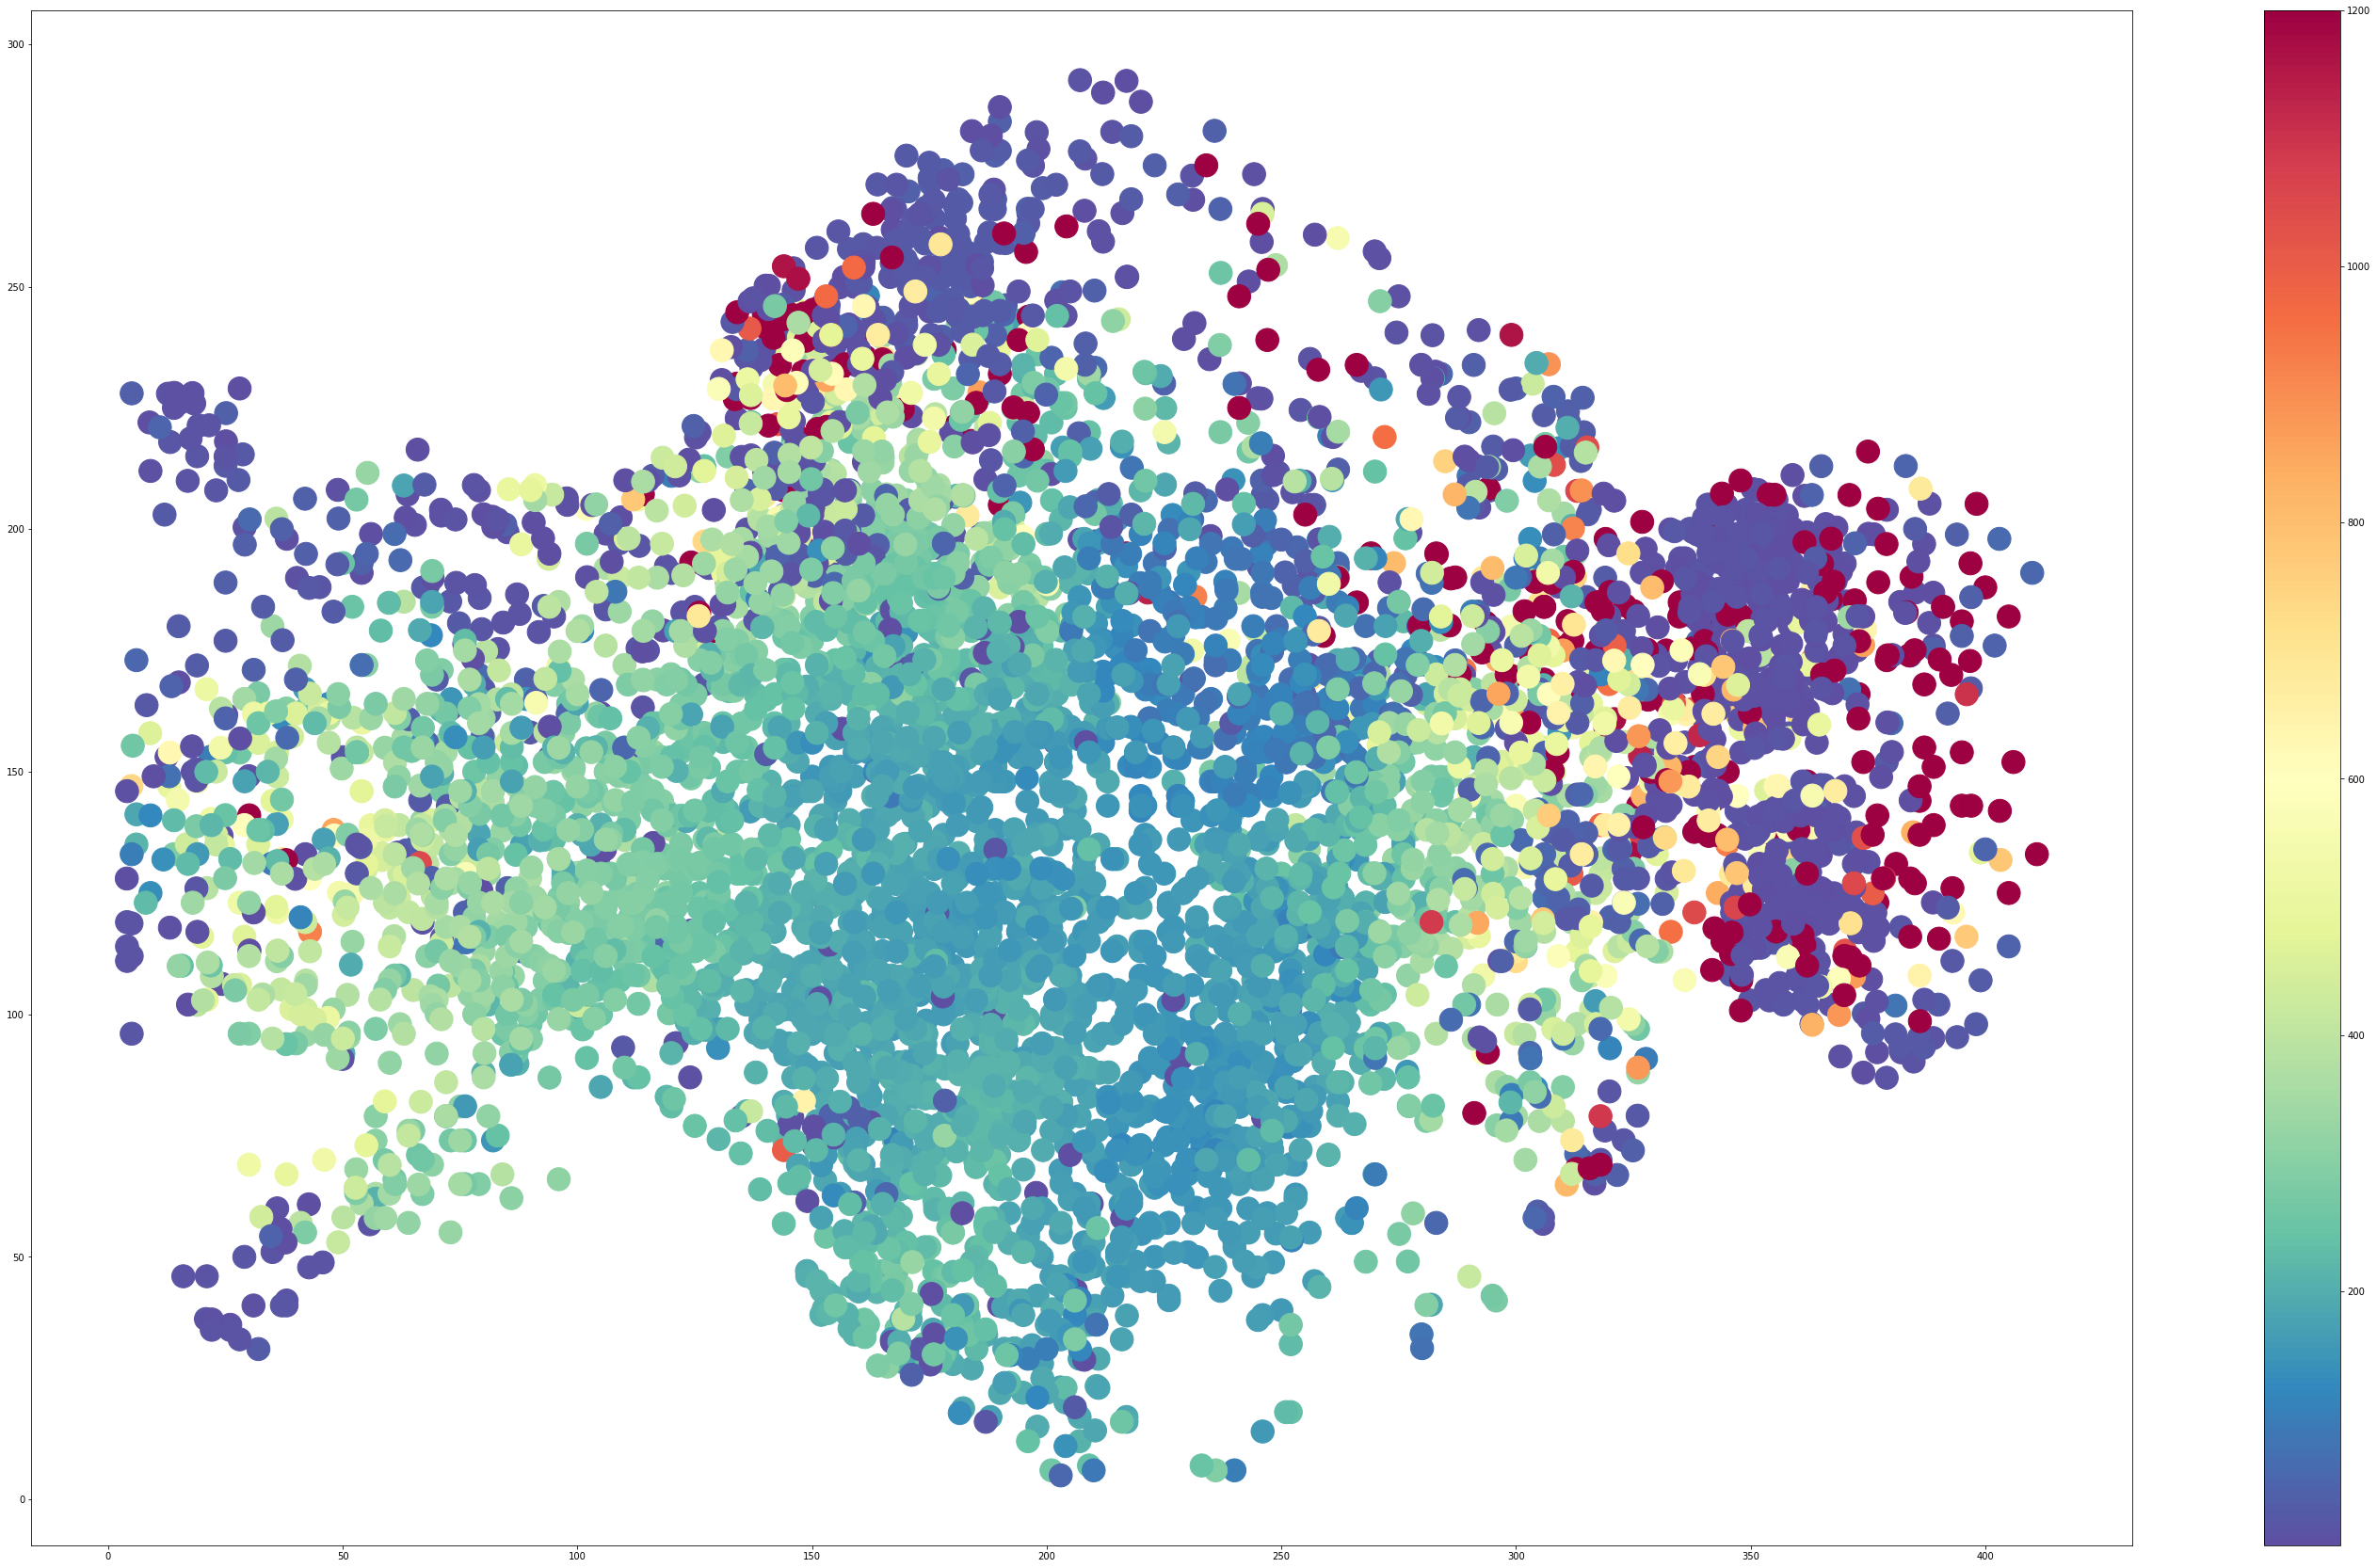

In [413]:
%matplotlib inline
c = 1
ocs    = Fish[foi]["Cond"][c]["OCoord"]
cs     = Fish[foi]["Cond"][c]["Coordinates"]
ftr    = Fish[foi]["Cond"][c]["Features"]
p_f    = Fish[foi]["Cond"][c]["Firing_p"]
bmi    = ftr["Brain Mask"] == 1

fig = plt.figure(figsize = (50,30))
sc  = plt.scatter(ocs[bmi,0], ocs[bmi,1], 600, c = params[:,1], cmap = 'Spectral_r')
plt.colorbar(sc)



array([57.30526304,  0.40634761])

## Detect avalanches

In [ ]:
# Detect activity in more than 3 connected ROIs
#----------------------------------------------------------------------------
for c in range(len(Fish[foi]["Cond"])):
    ftr      = Fish[foi]["Cond"][c]["Features"]
    bmi      = ftr["Brain Mask"] == 1
    
    pks      = Fish[foi]["Cond"][c]["Peaks"][bmi,:]
    nnb      = Fish[foi]["Cond"][c]["NNGraph"][bmi,:][:,bmi]

    mxv      = 8000
    mxi      = min((int(pks.shape[1] / mxv)) + 1, 2)  #clummmmmssssyyyyy
    
    Alist = []
    Rlist = []
    for i in range(mxi): 
        sid = range(i*mxv, min(pks.shape[1], (i+1)*mxv))
        pkg,avsz = cn.avalanche(pks[:,sid], nnb)
        Alist.append((pkg,avsz))
        
        # Set up random shuffled array for comparison
        #----------------------------------------------------------------
        rpks = copy.deepcopy(pks[:,sid])
        rpks = rpks.ravel()
        np.random.shuffle(rpks) 
        rpks = np.reshape(rpks, pks[:,sid].shape)
        
        rpkg,ravsz = cn.avalanche(rpks,nnb)
        Rlist.append((rpkg,ravsz))
        
    Fish[foi]["Cond"][c]["Avalanches"] = {"A":Alist, "R":Rlist}
    

Doing time point 0 of 7227
Doing time point 723 of 7227
Doing time point 1446 of 7227
Doing time point 2169 of 7227
Doing time point 2892 of 7227
Doing time point 3615 of 7227
Doing time point 4338 of 7227
Doing time point 5061 of 7227
Doing time point 5784 of 7227
Doing time point 6507 of 7227
Now calculating avalanche size
Doing time point 0 of 7227
Doing time point 723 of 7227
Doing time point 1446 of 7227
Doing time point 2169 of 7227
Doing time point 2892 of 7227
Doing time point 3615 of 7227
Doing time point 4338 of 7227
Doing time point 5061 of 7227
Doing time point 5784 of 7227
Doing time point 6507 of 7227
Now calculating avalanche size
Doing time point 0 of 8000
Doing time point 800 of 8000


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


Text(0.5, 0, 'Number of coactive cells / size of avalanche')

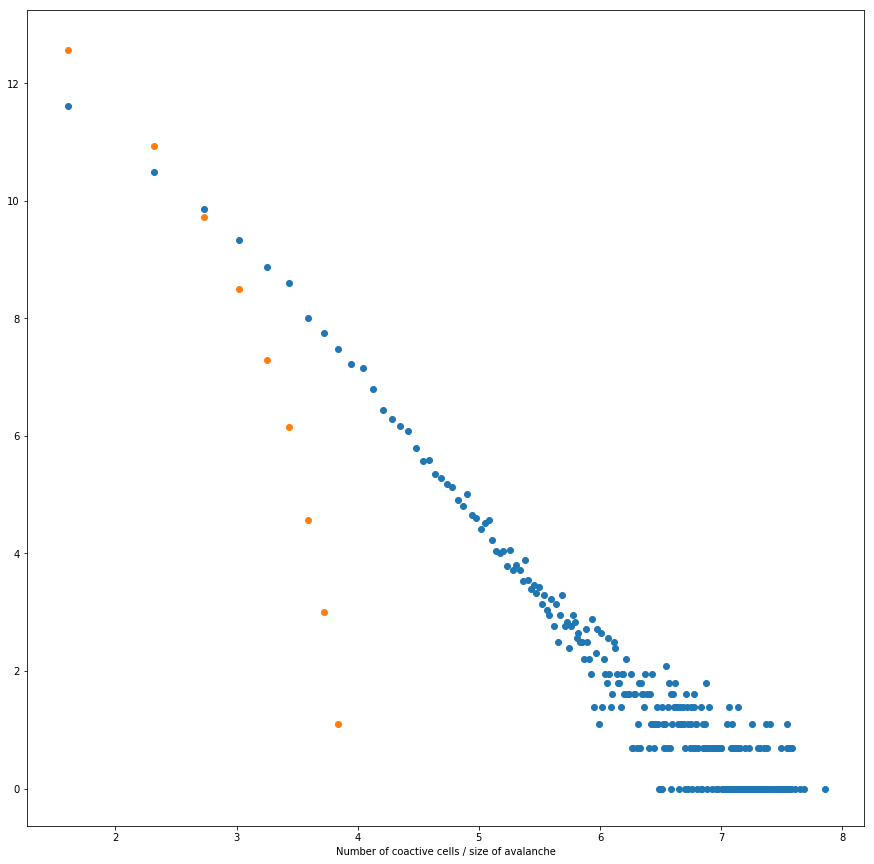

In [12]:
# Plot log-log histogram
#-----------------------------------------------------------------------------------------
a  = avsz[avsz >= 5]
ra = ravsz[ravsz >= 5]
ls = np.linspace(np.min(a), np.max(a), 500)

ah  = np.histogram(a, bins = ls)
rah = np.histogram(ra, bins = ls)

plt.figure(figsize=(15,15))
plt.scatter(np.log(ah[1][:-1]), np.log(ah[0]))
plt.scatter(np.log(rah[1][:-1]), np.log(rah[0]))
plt.xlabel('Number of coactive cells / size of avalanche')

In [ ]:
## Calculate correlation features

/Users/roschkoenig/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/roschkoenig/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<bound method Figure.tight_layout of <Figure size 1440x720 with 3 Axes>>

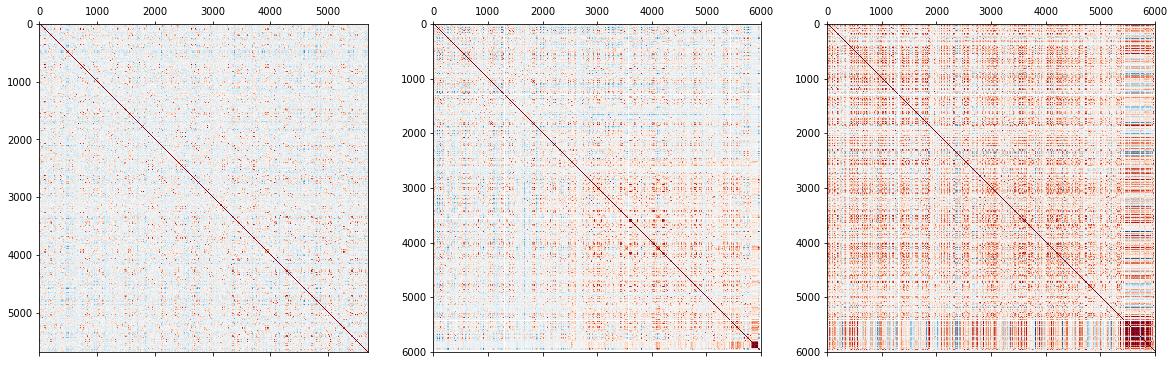

In [91]:
cnt = 0
fig,ax  = plt.subplots(1,3, figsize = (20,10))

for c in range(len(Fish[foi]["Cond"])):
    ftr      = Fish[foi]["Cond"][c]["Features"]
    dat      = Fish[foi]["Cond"][c]["Data"]
    bmi      = ftr["Brain Mask"] == 1
    atl      = ftr["Coexpression"][bmi]

    mxv      = 8000
    mxi      = min((int(dat.shape[1] / mxv)) + 1, 2)  #clummmmmssssyyyyy
    

    
    for i in range(mxi): 
        cnt = cnt + 1
        sid = range(i*mxv, min(dat.shape[1], (i+1)*mxv))
        d   = dat[bmi,:][:,sid]
        cor = np.corrcoef(d)
            
        # Plot correlation matrix ordered by k-means cluster
        #------------------------------------------------------------------------------------
        atstd   = np.argsort(atl)
        scor    = cor[atstd,:][:,atstd] 
        ax[cnt-1].matshow(cor, cmap = 'RdBu_r')

fig.tight_layout

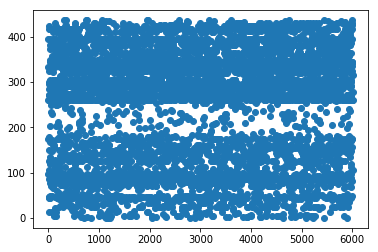

# Code RIP

In [ ]:
# recalculate coordinates according to original transform used for registration
#-----------------------------------------------------------------------------------
# Put back into voxel space
# Apply spacing and direction changes

# Transform coordinates to ZBB spain
aff1 = Ftrans + os.sep + 'cf2ref_R.mat'
aff2 = Ftrans + os.sep + 'cf2ref_S.mat'
syn  = Ftrans + os.sep + 'cf2ref_S.nii.gz'

c = 0
ftrans = Freg + os.sep + Fish[foi]["Name"] + os.sep + Fish[foi]["Cond"][c]["Name"] + os.sep + 'FUN2CF'
AFF1   = ftrans + os.sep + 'fun2cf_R.mat'
AFF2   = ftrans + os.sep + 'fun2cf_S.mat'
SYN    = ftrans + os.sep + 'fun2cf_S.nii.gz'

# Get labels from variety of ZBB templates (feature map)
cs = Fish[foi]["Cond"][c]["Coordinates"]
cs = pd.DataFrame(data = cs)
cs.columns = ['x', 'y', 'z']
ncs = ants.apply_transforms_to_points(3, cs, [aff1, aff2, syn, AFF1, AFF2, SYN])

# # Set up dummy Ants image to check orientation
# #------------------------------------------------------------------------------
# c   = 0
# sp  = Fish[foi]["spacing"]                       # spacing used for the current fish
# dm  = Fish[foi]["xy_size"]                       # dimensions of current fish's xy plane (in pixels? Don't know...)
# cs  = Fish[foi]["Cond"][c]["Coordinates"]        # coordinates of the point cloud derived from current fish
# ocs = np.divide(cs, sp)                          # Derive original (voxel count) coordinates

# ndim = np.multiply(rw.shape, rw.spacing)
# pt   = np.zeros(rw.shape)

# # ocs[:,0] = -ocs[:,0]
# # ocs[:,2] = -ocs[:,2]

# for p in ocs: pt[int(p[0]),int(p[1]),int(p[2])] = 1
# pt = ants.from_numpy(pt)
# pt.set_spacing(rw.spacing)
# pt.set_direction(rw.direction)





In [ ]:
# Use ZBB mask to exclude all non-brain voxels -- Assumes you have run cde_reg

# Load raw image and apply initial transform from registration
#------------------------------------------------------------------------------
rw = ants.image_read(Freg +os.sep+ Fish[foi]["Name"] +os.sep+ Fish[foi]["Cond"][c]["Name"] +os.sep+
                    'Raw' +os.sep+ Fish[foi]["Cond"][c]["Name"] + '.tif')
rw.set_direction(np.array([[-1.,0.,0.],[0.,1.,0.],[0.,0.,-1.]]))
rw.set_spacing([.3,.3,6.])

# Locate relevant transforms
#==============================================================================
# Confocal image to reference (ZBB) image
#------------------------------------------------------------------------------
aff1 = Ftrans + os.sep + 'ref2cf_R.mat'
aff2 = Ftrans + os.sep + 'ref2cf_S.mat'
syn  = Ftrans + os.sep + 'ref2cf_S.nii.gz'

# Functional image to confocal image
#------------------------------------------------------------------------------
c = 0
ftrans = Freg + os.sep + Fish[foi]["Name"] + os.sep + Fish[foi]["Cond"][c]["Name"] + os.sep + 'FUN2CF'
AFF1   = ftrans + os.sep + 'cf2fun_R.mat'
AFF2   = ftrans + os.sep + 'cf2fun_S.mat'
SYN    = ftrans + os.sep + 'cf2fun_S.nii.gz'

# Apply transformation to Z-brain atlas in ZBB space
#------------------------------------------------------------------------------
zba   = ants.image_read(Ftemps +os.sep+ 'z-brain.tif')
paj   = ants.image_read(Ftemps +os.sep+ 'pajevic1.tif')
cfc   = ants.image_read(Ftemps +os.sep+ 'Confoc.tif')

zba.set_spacing([.6,.6,2.])        # Original registration done on double resolution
paj.set_spacing([.6,.6,2.])        # Original registration done on double resolution
cfc.set_spacing([.3,.3,1.])        # Same as used in registration 
cfc.set_direction(np.array([[-1., 0., 0.],[0., 1., 0.],[0., 0., -1]]))

zba_t = ants.apply_transforms(cfc, zba, [aff1, aff2, syn], whichtoinvert = [True, True, False])
zba_t = ants.apply_transforms(rw, zba_t, [AFF1, AFF2, SYN], whichtoinvert = [True, True, False])
paj_t = ants.apply_transforms(cfc, paj, [aff1, aff2, syn], whichtoinvert = [True, True, False])
paj_t = ants.apply_transforms(rw, paj_t, [AFF1, AFF2, SYN], whichtoinvert = [True, True, False])



In [ ]:
# Confocal image to reference (ZBB) image
#------------------------------------------------------------------------------
aff1 = Ftrans + os.sep + 'cf2ref_R.mat'
aff2 = Ftrans + os.sep + 'cf2ref_S.mat'
syn  = Ftrans + os.sep + 'cf2ref_S.nii.gz'

# Functional image to confocal image
#------------------------------------------------------------------------------
c = 0
ftrans = Freg + os.sep + Fish[foi]["Name"] + os.sep + Fish[foi]["Cond"][c]["Name"] + os.sep + 'FUN2CF'
AFF1   = ftrans + os.sep + 'fun2cf_R.mat'
AFF2   = ftrans + os.sep + 'fun2cf_S.mat'
SYN    = ftrans + os.sep + 'fun2cf_S.nii.gz'

pdcs = pd.DataFrame(data = ocs)
pdcs.columns = ['x', 'y', 'z']
npts = ants.apply_transforms_to_points(3, pdcs, [aff1, aff2, syn])
npts = ants.apply_transforms_to_points(3, npts, [AFF1, AFF2, SYN])


# Code Grave - RIP

In [ ]:
# Plot time courses of changes in firing probability
#------------------------------------------------------------------------------
fig, ax = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 2]}, 
                       figsize = (60,20))
fig.tight_layout()

for r in regs:
    cid = np.where(valb == r)[0]
    pfbl_c = pf_bl[cid,:]
    cid = np.where(valp == r)[0]
    pfpt_c = pf_pt[cid,:]
    
    ax[0].plot(np.log(np.mean(pfbl_c, axis = 0)+1))
    ax[1].plot(np.log(np.mean(pfpt_c, axis = 0)+1))

In [ ]:
# Plot firing probability relationship with vglut and 
#-----------------------------------------------------------------------------
bb = Fish[foi]["Cond"][0]["Features"]["Brain Mask"] == 1
bp = Fish[foi]["Cond"][1]["Features"]["Brain Mask"] == 1
vglut_b = stats.zscore(Fish[foi]["Cond"][0]["Features"]["vglut-DsRed"][bb])
vglut_p = stats.zscore(Fish[foi]["Cond"][1]["Features"]["vglut-DsRed"][bp])
gad1b_b = stats.zscore(Fish[foi]["Cond"][0]["Features"]["gad1b-Gal4"][bb])
gad1b_p = stats.zscore(Fish[foi]["Cond"][1]["Features"]["gad1b-Gal4"][bp])

fig, ax = plt.subplots(1,1, sharex = True, sharey = True, figsize = (15,5))
cnt     = 5        # centile 
data    = pd.DataFrame(columns = ['p(firing)', 'group'])
rown    = 0

rat = stats.zscore(vglut_b) / stats.zscore(gad1b_b)
loe = np.percentile(rat, cnt); loe = np.where(rat < loe)[0]; 
hie = np.percentile(rat, 100-cnt); hie = np.where(rat > hie)[0];
for l in loe: data.loc[rown] = ([np.mean(pf_bl[bb,:], axis = 1)[l] + .001, 0]); rown = rown+1
for h in hie: data.loc[rown] = ([np.mean(pf_bl[bb,:], axis = 1)[h] + .001, 3]); rown = rown+1

rat = stats.zscore(vglut_p) / stats.zscore(gad1b_p)
hie = np.percentile(rat, 100-cnt); hie = np.where(rat > hie)[0];  
loe = np.percentile(rat, cnt); loe = np.where(rat < loe)[0];  
for l in loe: data.loc[rown] = ([np.mean(pf_pt[bp,:30], axis = 1)[l] + .001, 1]); rown = rown+1
for h in hie: data.loc[rown] = ([np.mean(pf_pt[bp,:30], axis = 1)[h] + .001, 4]); rown = rown+1

for l in loe: data.loc[rown] = ([np.mean(pf_pt[bp,30:], axis = 1)[l] + .001, 2]); rown = rown+1
for h in hie: data.loc[rown] = ([np.mean(pf_pt[bp,30:], axis = 1)[h] + .001, 5]); rown = rown+1

data['normalised'] = stats.boxcox(data['p(firing)'])[0]
ldat = []
for d in np.unique(data['group']):
    ldat.append(data['p(firing)'][data['group'] == d].as_matrix())
plt.violinplot(ldat)